# **Exercício 9.1**

### Utilizando o dataset Eletrical_Production.csv (disponível no repositório da disciplina) faça uma previsão de série temporal utilizando LSTM para prever os últimos 20% de dias do dataset (conjunto de treino).

---



In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

In [324]:
#Importa Base de Dados
fpath='/content/sample_data/Eletrical_Production.csv'

#Cria Data Frame a partir do arquivo externo
df=pd.read_csv(fpath, usecols=[1], engine='python')

#exibe os primeiros registros
df.head()

,IPG2211A2N
0,3.3842
1,3.4100
2,3.4875
3,3.5133
4,3.5133


In [325]:
#Converte o formato para Float32
X = df.values
X = X.astype('float32')

#Coloca a Data como índice do data frame para melhor visualização do Gráfico
X = pd.read_csv(fpath, index_col='DATE', parse_dates=['DATE'])
X.head()

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


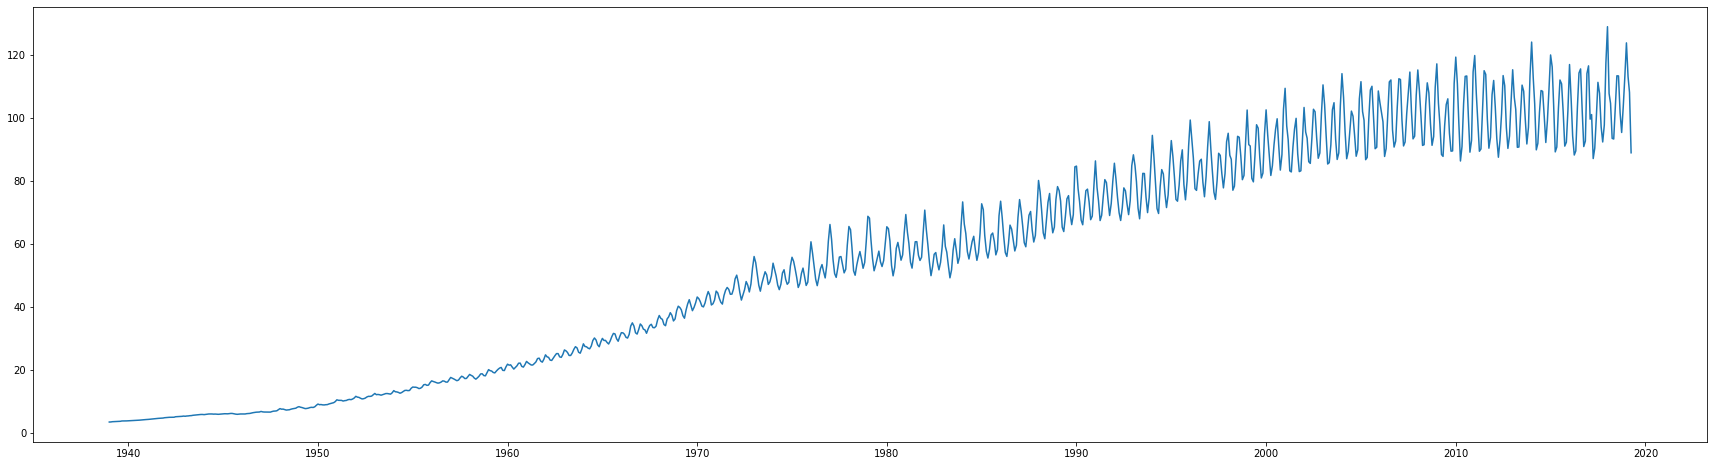

In [326]:
#Exibe gráfico
plt.figure(figsize=(30,8))
plt.plot(X)

In [327]:
#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [328]:
#Separa 80% da base para treino e 20% para teste
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train = X[0:train_size,:]
test =  X[train_size:len(X),:]
print(train_size)
print(test_size)

771
193


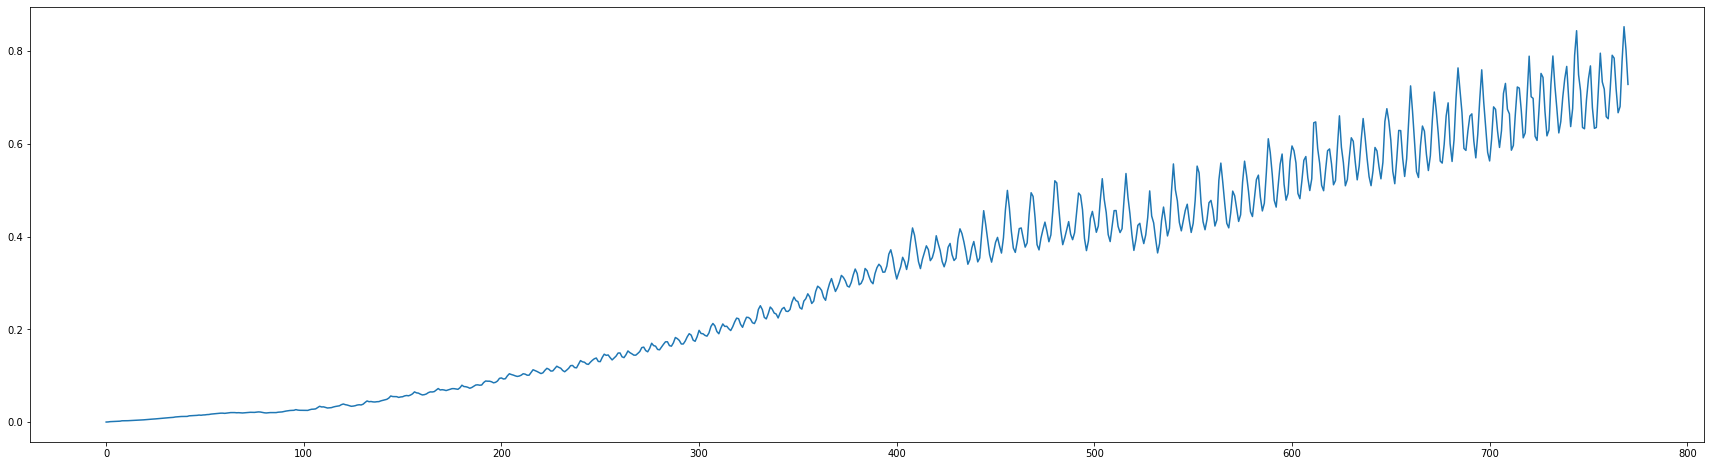

In [329]:
#Exibe gráfico dos dados de treino
plt.figure(figsize=(30,8))
plt.plot(train)

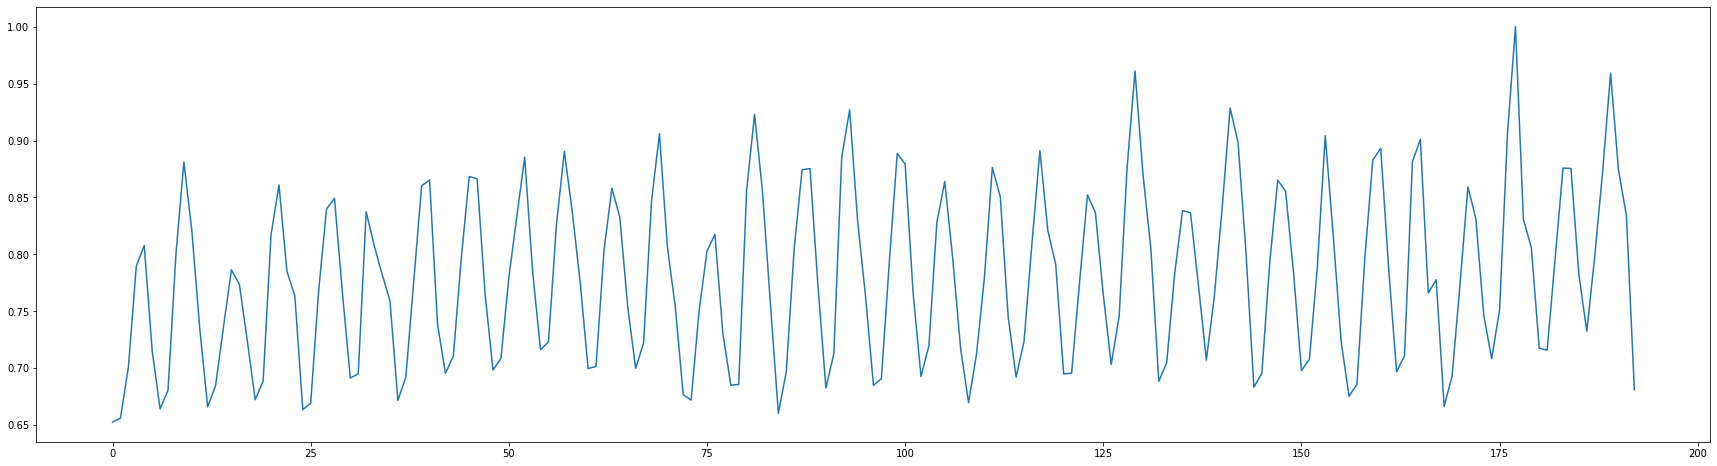

In [330]:
#Exibe gráfico dos dados de teste
plt.figure(figsize=(30,8))
plt.plot(test)

In [331]:
#Cria função para gerar um dataset de acordo com o look_back(atraso) informado 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [332]:
#quantidade de atrasos
look_back = 3

#Chama função que gera os datasets de teste e treino de acordo com o look_back
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [333]:
X_train.shape

(767, 3)

In [334]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [338]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1))) 
model.add(Dense(1)) #Camada densa sem função de ativação. Queremos uma saída linear, para capturar tantos os outputs positivos quanto negativos
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
767/767 [==============================] - 2s 1ms/step - loss: 0.0549 - mae: 0.1684
Epoch 2/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0022 - mae: 0.0332
Epoch 3/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0025 - mae: 0.0348
Epoch 4/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0020 - mae: 0.0298
Epoch 5/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0020 - mae: 0.0304
Epoch 6/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0019 - mae: 0.0298
Epoch 7/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0017 - mae: 0.0284
Epoch 8/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0017 - mae: 0.0272
Epoch 9/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0019 - mae: 0.0307
Epoch 10/100
767/767 [==============================] - 1s 1ms/step - loss: 0.0018 - mae: 0.0293
Epoch 11/100
767/767 [=================

In [339]:
# Predições do conjunto de treino e teste
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [340]:
# Faz a transformação inversa das predições, ou seja, vou voltar do estado normalizado para o estado original
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [341]:
# Calcula o RMSE - Raiz do erro médio quadradico
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 6.67 RMSE


In [342]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [343]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

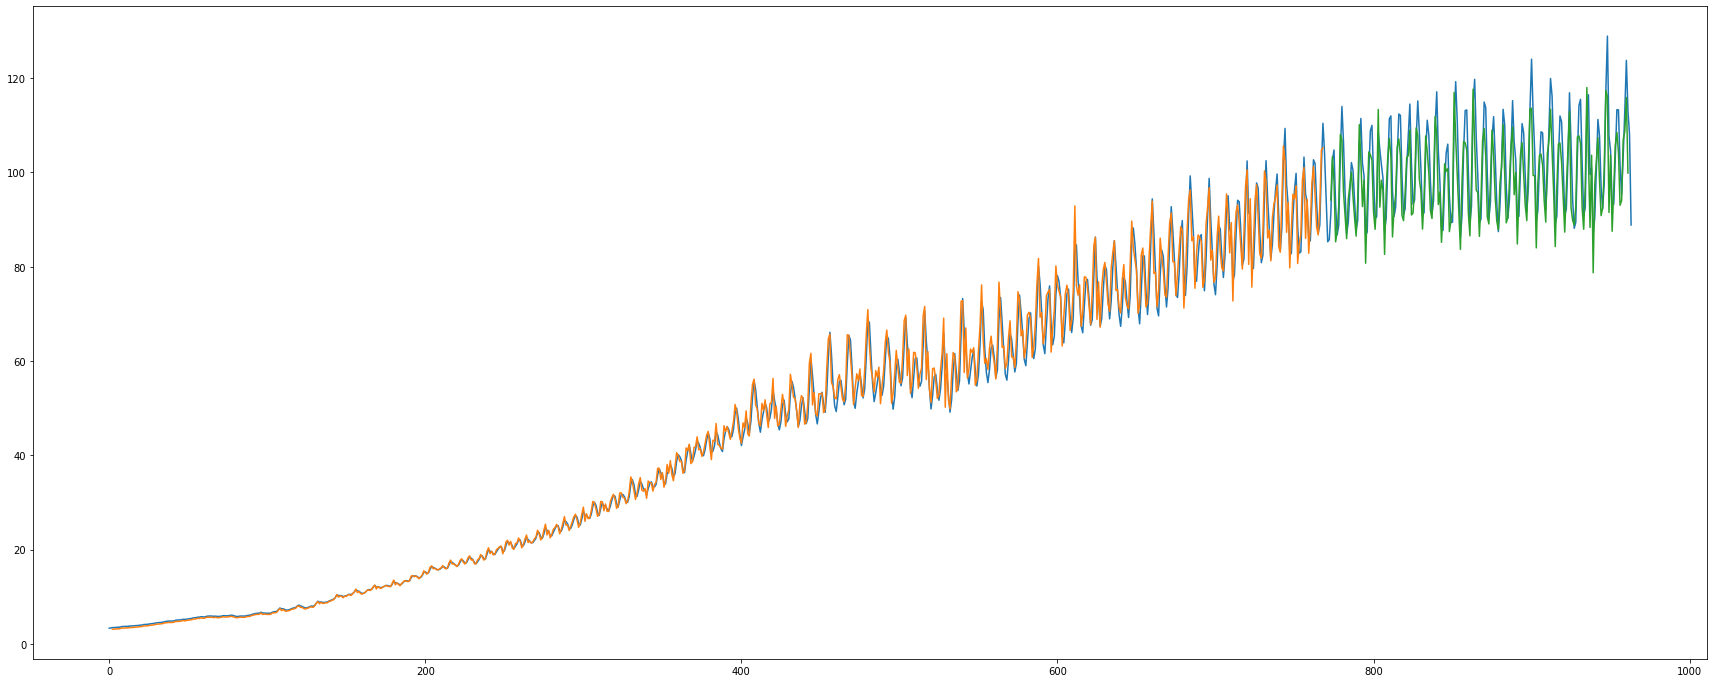

In [344]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(30,12))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()